# Perkenalan

Grade Challenge 7

Nama: Ridwan Muhammad Syahrul

Batch: RMT-029

Program ini dimaksudkan untuk membuat model yang akan digunakan untuk mengecek review dari customer Airline apakah customer tersebut mengirimkan review kelas Promoter (Positive Review), Passive (Neutral Review), Detractor (Negative Review).

# A. Libraries Import

In [39]:
# Import Libraries

import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Reshape, Bidirectional, GRU, BatchNormalization, SimpleRNN
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras import Model

import pickle

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# B. Data Load

Data didapatkan pada website kaggle dan data yang dipakai adalah https://www.kaggle.com/datasets/malharkhatu/airline-passenger-reviews/data

In [4]:
# Data loading
df = pd.read_csv("/content/drive/MyDrive/Datasets/Airline Passenger Reviews.csv")

df.head()

,customer_review,NPS Score
0,London to Izmir via Istanbul. First time I'd ...,Passive
1,Istanbul to Bucharest. We make our check in i...,Detractor
2,Rome to Prishtina via Istanbul. I flew with t...,Detractor
3,Flew on Turkish Airlines IAD-IST-KHI and retu...,Promoter
4,Mumbai to Dublin via Istanbul. Never book Tur...,Detractor


Pada dataset ini, terdapat 2 atribut, yaitu customer_review dan NPS Score. Atribut customer_review adalah data yang berisi mengenai review customer mengenai pengalaman yang mereka rasakan dengan airline disini (Nama airline tidak tertata dalam dataset). Atribut NPS Score merupakan data yang berisi sentimen customer tersebut berdasarkan review yang telah dikirimkan oleh customer. Atribut NPS Score memiliki 3 buah kelas, yaitu Passive, Detractor, dan Promoter.
- Passive adalah kelas yang mengkategorikan sebuah review customer yang tidak memberikan efek terhadap marketing Airline (Neutral).
- Detractor adalah kelas yang mengkategorikan sebuah review customer yang dapat memberikan efek negatif terhadap marketing Airline.
- Promoter adalah kelas yang mengkategorikan sebuah review customer yang dapat memberikan efek positif terhadap marketing Airline.

In [4]:
# Mengecek info dari dataset, yaitu jumlah kolom, banyak data, dan type data tiap kolom
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64017 entries, 0 to 64016
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   customer_review  64017 non-null  object
 1   NPS Score        64017 non-null  object
dtypes: object(2)
memory usage: 1000.4+ KB


In [7]:
# Pengubahan nama kolom NPS Score
df.columns = df.columns.str.replace('NPS Score', 'nps_score')

In [6]:
# Mengecek jumlah data yang null
df.isnull().sum()

customer_review    0
nps_score          0
dtype: int64

In [7]:
# Mengecek jumlah data duplikat
df.duplicated().sum()

4625

In [5]:
df[df['customer_review'].duplicated() == True]

,customer_review,nps_score
1091,LIS-IST B737-800. Check in OK. Flight on Time....,Promoter
1110,BKK-IST-ARN on A330 and then A321. Flight from...,Detractor
1131,Flew back with TK 1955 business class from Ist...,Detractor
1140,We flew a family of 6 CGK-TLV and TLV-AMS all ...,Passive
1170,My recent flight on Turkish Airlines was with ...,Detractor
...,...,...
62366,Flew from LAX to Copenhagen on 9/2/2014 return...,Promoter
62367,Outbound 25/08/14 Flight DY5293. Inbound 03/09...,Promoter
62397,Flew VNO-ARN-CPH. First sector VNO to ARN I co...,Detractor
62423,My son and I flew no frills with carry-on Oakl...,Promoter


Karena data duplikat pada dataset ini adalah customer review yang sama persis, dapat diasumsikan bahwa data duplikat tersebut datang dari customer yang sama karena sangat kecil kemungkinan 2 customer yang memiliki review yang persis sama, sehingga data duplikat dapat di drop. Data duplikat ini kemungkinan terjadi karena ketika user meng-submit reviewnya, user memencet tombol submit lebih dari satu kali sehingga system menyimpan review sebanyak berapa kali tombol submit dipencet.

In [5]:
# Data duplikat di-drop
df.drop_duplicates(inplace=True)

In [10]:
# Mengecek jumlah unique value pada masing-masing column
list_column = df.columns.tolist()

for x in list_column:
    print('Column', x, 'has:', len(df[x].unique()))

Column customer_review has: 59391
Column nps_score has: 3


# C. Exploratory Data Analysis

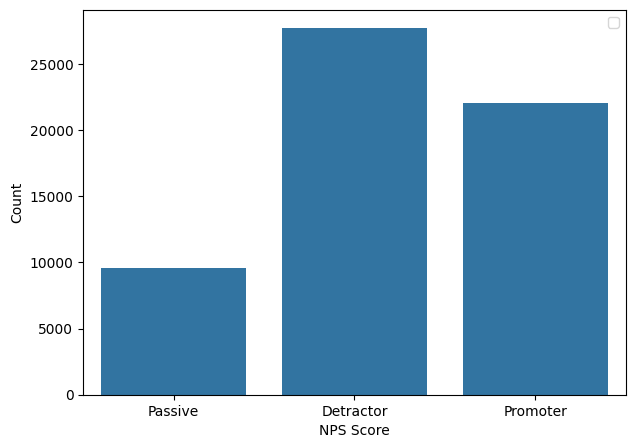

nps_score
Detractor    27731
Promoter     22087
Passive       9574
Name: count, dtype: int64

In [11]:
# Visualisasi NPS Score Customer
fig, ax = plt.subplots(figsize=(7,5))
sns.countplot(x = 'nps_score', data = df)
plt.xlabel('NPS Score')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

df['nps_score'].value_counts()

Dari hasil visualisasi, review yang termasuk sebagai kelas Detractor ada sebanyak 27731 review, untuk kelas Promoter ada sebanyak 22087, dan untuk kelas Passive ada sebanyak 9574. Dapat disimpulkan bahwa dataset ini termasuk balance antara Detractor dan Promoter + Passive.

In [8]:
# Mengubah value pada atribut nps_score dari string menjadi integer

df['nps_score'].replace({'Detractor':0 , 'Promoter':2 , 'Passive':1} , inplace = True) # converting the values of nps score in number

## Wordcloud Before Preprocessing

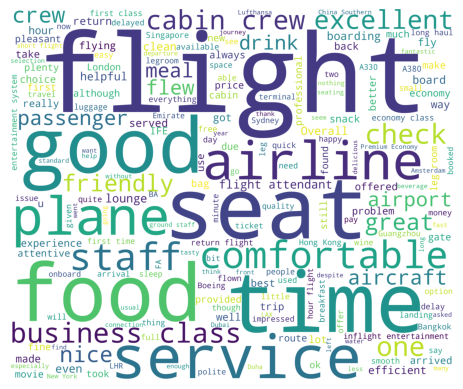

In [18]:
# positive sentiment analysis
df1 = df[df['nps_score']== 2]
words = ' '.join(df1['customer_review'].astype(str))
cleaned_word = ' '.join([word for word in words.split() if not word.startswith('@')])

wordcloud = WordCloud(background_color = 'white' , stopwords = STOPWORDS , width = 3000 , height = 2500).generate(''.join(cleaned_word))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Kata-kata yang sering muncul pada review Promoter adalah flight, cabin crew, excellent, good, airline, plane, seta, staff, comfortable, food, time, service, businiess class, dll.

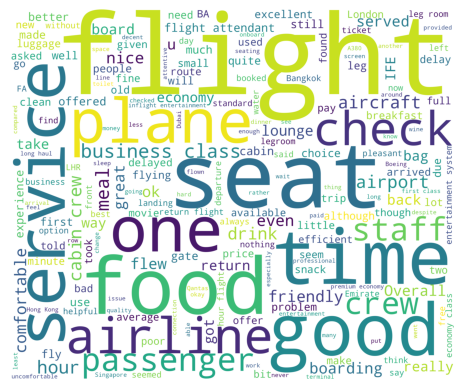

In [19]:
# neutral sentiment analysis
df1 = df[df['nps_score']== 1]
words = ' '.join(df1['customer_review'].astype(str))
cleaned_word = ' '.join([word for word in words.split() if not word.startswith('@')])

wordcloud = WordCloud(background_color = 'white' , stopwords = STOPWORDS , width = 3000 , height = 2500).generate(''.join(cleaned_word))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Kata-kata yang sering muncul pada review Passive adalah flight, seat, plane, service, good, airline passanger, check, great, meal, staff, dll.

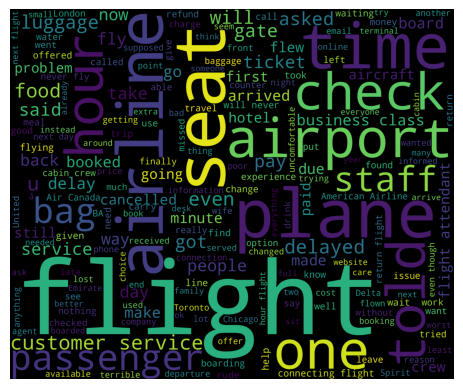

In [20]:
# negative sentiment analysis
df1 = df[df['nps_score']== 0]
words = ' '.join(df1['customer_review'].astype(str))
cleaned_word = ' '.join([word for word in words.split() if not word.startswith('@')])

wordcloud = WordCloud(background_color = 'black' , stopwords = STOPWORDS , width = 3000 , height = 2500).generate(''.join(cleaned_word))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Kata-kata yang sering muncul pada review Detractor adalah flight, seat, airport, staff, check, time, airpline, customer service, problem, luggage, dll.

# D. Feature Engineering

## Preprocessing

In [9]:
# Membuat copy dataframe untuk diolah selama proses feature engineering
df_fe = df.copy()

In [10]:
# Define Stopwords
l1  = list(stopwords.words('english'))

# Define Stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

In [11]:
def text_preprocessing(text):
  # Case folding
  text = text.lower()

  # Mention removal
  text = re.sub("@[A-Za-z0-9_]+", " ", text)

  # Hashtags removal
  text = re.sub("#[A-Za-z0-9_]+", " ", text)

  # Newline removal (\n)
  text = re.sub(r"\\n", " ",text)

  # Whitespace removal
  text = text.strip()

  # URL removal
  text = re.sub(r"http\S+", " ", text)
  text = re.sub(r"www.\S+", " ", text)

  # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
  text = re.sub("[^A-Za-z\s']", " ", text)

  # Tokenization
  tokens = word_tokenize(text)

  # Stopwords removal
  tokens = [word for word in tokens if word not in l1]

  # Stemming
  tokens = [stemmer.stem(word) for word in tokens]

  # Combining Tokens
  text = ' '.join(tokens)

  return text

In [12]:
# Applying Text Preprocessing to the Dataset

df_fe['text_processed'] = df_fe['customer_review'].apply(lambda x: text_preprocessing(x))
df_fe

,customer_review,nps_score,text_processed
0,London to Izmir via Istanbul. First time I'd ...,1,london izmir via istanbul first time 'd flown ...
1,Istanbul to Bucharest. We make our check in i...,0,istanbul bucharest make check airport take lug...
2,Rome to Prishtina via Istanbul. I flew with t...,0,rome prishtina via istanbul flew compani sever...
3,Flew on Turkish Airlines IAD-IST-KHI and retu...,2,flew turkish airlin iad ist khi return khi ist...
4,Mumbai to Dublin via Istanbul. Never book Tur...,0,mumbai dublin via istanbul never book turkish ...
...,...,...,...
64012,London to Kiev Simferopol London. Overall a pr...,0,london kiev simferopol london overal pretti go...
64013,Brussels-Kiev-Brussels Business Class: no dela...,0,brussel kiev brussel busi class delay seat ok ...
64014,SPL-KBP vv operated in code share with KLM don...,0,spl kbp vv oper code share klm done time term ...
64015,Kiev-Vienna. Check in was slow but after that ...,0,kiev vienna check slow good plane new look cle...


## Wordcloud After Preprocessing

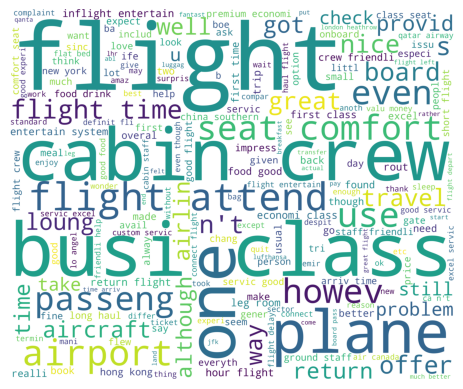

In [33]:
# positive sentiment analysis
df2 = df_fe[df_fe['nps_score']== 2]
words = ' '.join(df2['text_processed'].astype(str))
cleaned_word = ' '.join([word for word in words.split() if not word.startswith('@')])

wordcloud = WordCloud(background_color = 'white' , stopwords = STOPWORDS , width = 3000 , height = 2500).generate(''.join(cleaned_word))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Setelah dilakukan preprocessing, kata-kata yang sering diketik dan berhubungan dengan review Promoter adalah flight, cabin crew, busi class, plane, airport, seat comfort, time, provid, great, nice, offer. Beberapa kata terlihat seperti kata yang terpotong, hal ini terjadi karena digunakannya stemmer pada tahap text processing

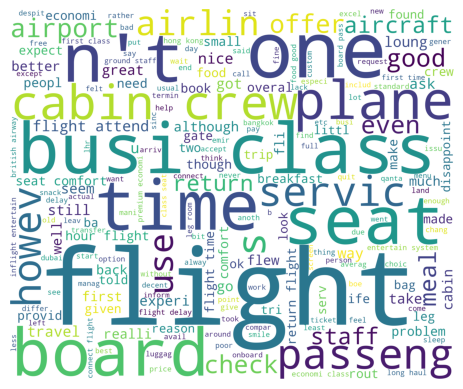

In [34]:
# neutral sentiment analysis
df2 = df_fe[df_fe['nps_score']== 1]
words = ' '.join(df2['text_processed'].astype(str))
cleaned_word = ' '.join([word for word in words.split() if not word.startswith('@')])

wordcloud = WordCloud(background_color = 'white' , stopwords = STOPWORDS , width = 3000 , height = 2500).generate(''.join(cleaned_word))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Setelah dilakukan preprocessing, kata-kata yang sering diketik dan berhubungan dengan review Passive adalah flight, seat, busi class, cabin crew, seat, time, good, offer, board, passeng. Beberapa kata terlihat seperti kata yang terpotong, hal ini terjadi karena digunakannya stemmer pada tahap text processing.

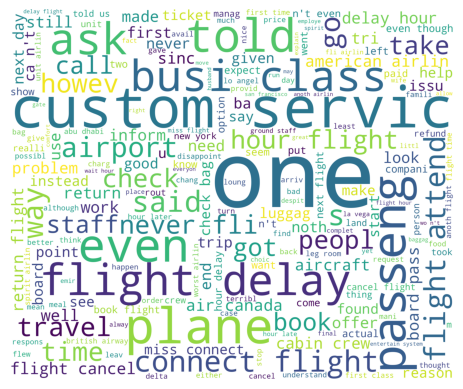

In [35]:
# negative sentiment analysis
df2 = df_fe[df_fe['nps_score']== 0]
words = ' '.join(df2['text_processed'].astype(str))
cleaned_word = ' '.join([word for word in words.split() if not word.startswith('@')])

wordcloud = WordCloud(background_color = 'white' , stopwords = STOPWORDS , width = 3000 , height = 2500).generate(''.join(cleaned_word))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Setelah dilakukan preprocessing, kata-kata yang paling sering diketik dan berhubungan pada review Detractor adalah delay, cancel, book, hour, miss, custom servic, busi class, dll. Beberapa kata terlihat seperti kata yang terpotong, hal ini terjadi karena digunakannya stemmer pada tahap text processing

## Data Splitting

In [22]:
# Data Splitting

X_tr_val, X_ts, y_tr_val, y_ts = train_test_split(df_fe.text_processed,
                                                    df_fe.nps_score,
                                                    test_size=0.20,
                                                    random_state=25,
                                                    stratify=df_fe.nps_score)

X_tr, X_val, y_tr, y_val = train_test_split(X_tr_val,
                                                  y_tr_val,
                                                  test_size=0.15,
                                                  random_state=25,
                                                  stratify=y_tr_val)

print('Train Size : ', X_tr.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_ts.shape)

Train Size :  (40386,)
Val Size   :  (7127,)
Test Size  :  (11879,)


In [23]:
# Change Target to One Hot Encoding

y_tr_ohe = to_categorical(y_tr)
y_val_ohe = to_categorical(y_val)
y_ts_ohe = to_categorical(y_ts)
y_tr_ohe

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

# E. Model Building

## Text Vectorization

In [24]:
# Get Vocabularies

Vectorize = CountVectorizer()
X_tr_vec = Vectorize.fit_transform(X_tr)
X_ts_vec = Vectorize.transform(X_ts)

X_tr_vec

<40386x21553 sparse matrix of type '<class 'numpy.int64'>'
	with 2221086 stored elements in Compressed Sparse Row format>

In [25]:
# Finding the Number of Vocabs and Max Token Length in One Document

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_tr])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  21553
Maximum Sentence Length :  692 tokens


In [26]:
# Text Vectorization

text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,))

text_vectorization.adapt(X_tr)

In [31]:
# Example Result

## Document example
print('Document example')
print(df_fe.text_processed[0])
print('')

## Result of Text Vectorization
print('Result of Text Vectorization')
print(text_vectorization([df_fe.text_processed[0]]))
print('Vector size : ', text_vectorization([df_fe.text_processed[0]]).shape)

Document example
london izmir via istanbul first time 'd flown tk found good air cabin crew plane food nice great ground ground staff call centr comput system flight lhr delay miss connect istanbul ground staff n't speak english given contradictori instruct could speak littl english eventu got flight izmir three hour later n't easi process made wors vast distanc one walk gate cavern new airport also 'd phone tk call centr base ukrain pay extra way extra leg room seat howev departur time kept chang seat kept chang return leg london istanbul given extra leg room seat luckili spare exit row seat cabin crew sort overal think cabin crew plane good ground staff call centr staff need better train need better comput system softwar work

Result of Text Vectorization
tf.Tensor(
[[  99 3420   43  296   30    5  447  194 1276  174    9   37   23   15
    16   10   80   62  148  148   17   81 1314 1125  130    2  238   21
   117   72  296  148   17    7  430  336  145 5467 1257   25  430  144
   33

In [32]:
# View the Top 20 Tokens (Sorted by the Highest Frequency of Appearance)

text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'flight',
 'seat',
 'airlin',
 'time',
 'servic',
 'nt',
 'hour',
 'good',
 'food',
 'check',
 'would',
 'fli',
 'board',
 'crew',
 'plane',
 'staff',
 'one',
 'get']

## Word Embedding

In [29]:
# Embedding

embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len,
                      trainable=False)

In [38]:
# Example Result

## Document example
print('Document example')
print(df_fe.text_processed[0])
print('')

## Result of Text Vectorization
print('Result of  Text Vectorization')
print(text_vectorization([df_fe.text_processed[0]]))
print('Vector size : ', text_vectorization([df_fe.text_processed[0]]).shape)
print('')

## Result of  Embedding
print('Result of  Embedding')
print(embedding(text_vectorization([df_fe.text_processed[0]])))
print('Vector size : ', embedding(text_vectorization([df_fe.text_processed[0]])).shape)

Document example
london izmir via istanbul first time 'd flown tk found good air cabin crew plane food nice great ground ground staff call centr comput system flight lhr delay miss connect istanbul ground staff n't speak english given contradictori instruct could speak littl english eventu got flight izmir three hour later n't easi process made wors vast distanc one walk gate cavern new airport also 'd phone tk call centr base ukrain pay extra way extra leg room seat howev departur time kept chang seat kept chang return leg london istanbul given extra leg room seat luckili spare exit row seat cabin crew sort overal think cabin crew plane good ground staff call centr staff need better train need better comput system softwar work

Result of  Text Vectorization
tf.Tensor(
[[  99 3420   43  296   30    5  447  194 1276  174    9   37   23   15
    16   10   80   62  148  148   17   81 1314 1125  130    2  238   21
   117   72  296  148   17    7  430  336  145 5467 1257   25  430  144
   3

## Model Training

Pada base model, digunakan metode training dengan SimpleRNN. Sebelum memasuki hidden layer, hasil input user akan melalui proses text vectorization lalu memasuki proses embedding. Setelah itu, masuk ke hidden layer. Hidden layer yang digunakan ada 2 buah, masing-masing hidden layer pertama dan kedua memiliki neuron sebanyak 30 dan 15 dengan menggunakan activation RelU. Lalu untuk outputnya terdapat 3 neuron dikarenakan outputnya memiliki 3 possible outcome.

In [31]:
# Model Training using SimpleRNN
%%time

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Reshape, SimpleRNN

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_base = Sequential()
model_base.add(text_vectorization)
model_base.add(embedding)
model_base.add(SimpleRNN(30, activation = 'relu', return_sequences=True, kernel_initializer=tf.keras.initializers.HeUniform(seed)))
model_base.add(SimpleRNN(15, activation = 'relu', kernel_initializer=tf.keras.initializers.HeUniform(seed)))
model_base.add(Dense(3, activation='softmax'))

model_base.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

model_base_hist = model_base.fit(X_tr, y_tr_ohe, epochs=25, validation_data=(X_val, y_val_ohe))

Epoch 1/25
1263/1263 [==============================] - 365s 286ms/step - loss: 1.0212 - accuracy: 0.4664 - val_loss: 1.0181 - val_accuracy: 0.4670
Epoch 2/25
1263/1263 [==============================] - 353s 280ms/step - loss: 1.0189 - accuracy: 0.4669 - val_loss: 1.0205 - val_accuracy: 0.4670
Epoch 3/25
1263/1263 [==============================] - 354s 280ms/step - loss: 1.0188 - accuracy: 0.4669 - val_loss: 1.0178 - val_accuracy: 0.4670
Epoch 4/25
1263/1263 [==============================] - 355s 281ms/step - loss: 1.0187 - accuracy: 0.4669 - val_loss: 1.0177 - val_accuracy: 0.4670
Epoch 5/25
1263/1263 [==============================] - 356s 282ms/step - loss: 259067.1250 - accuracy: 0.4610 - val_loss: 1.0177 - val_accuracy: 0.4670
Epoch 6/25
1263/1263 [==============================] - 355s 281ms/step - loss: 1.0178 - accuracy: 0.4669 - val_loss: 1.0177 - val_accuracy: 0.4670
Epoch 7/25
1263/1263 [==============================] - 353s 279ms/step - loss: 1.0178 - accuracy: 0.4669 -

## Model Evaluation

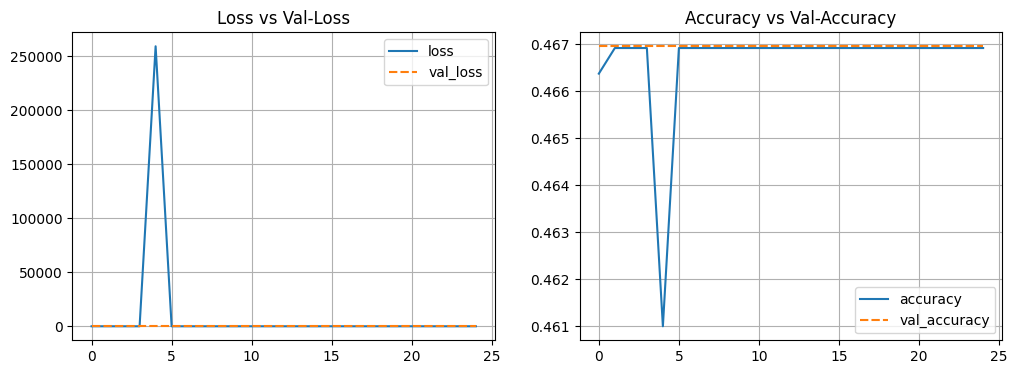

In [32]:
# model evaluation
model_base_hist_df = pd.DataFrame(model_base_hist.history)

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_base_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_base_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.show()

Dari hasil training base model, terlihat bahwa model training tidak terjadi kenaikan maupun penurunan performa akurasi dan juga loss. Hal ini disebabkan karena dataset sudah jenuh sehingga sudah tidak bisa ditingkatkan lagi akurasinya, sehingga diperlukan model improvement. Ada pula nilai spike yang terlihat pada grafik, hal ini kemungkinan terjadi karena pada saat running program, desktop masuk ke mode sleep sehingga cukup mengganggu proses training yang berlangsung.

In [35]:
# model evaluation (test-set)
y_pred_mod = model_base.predict(X_ts)
y_pred_base_class = np.argmax(y_pred_mod, axis=1)
y_pred_base_class

f1_model_base = f1_score(y_ts, y_pred_base_class, average='weighted')

print('F1 Score - Test Set   : ', round(f1_model_base,2), '\n')
print('Classification Report : \n', classification_report(y_ts, y_pred_base_class), '\n')

372/372 [==============================] - 26s 70ms/step
F1 Score - Test Set   :  0.3 

Classification Report : 
               precision    recall  f1-score   support

           0       0.47      1.00      0.64      5546
           1       0.00      0.00      0.00      1915
           2       0.00      0.00      0.00      4418

    accuracy                           0.47     11879
   macro avg       0.16      0.33      0.21     11879
weighted avg       0.22      0.47      0.30     11879
 



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# ANN Improvement (Bidrectional SimpleRNN)

## Embedding Layer

In [40]:
# Embedding

embedding_layer = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len,
                      trainable=False)

## Model Training

Pada improvement model, digunakan metode training dengan SimpleRNN. Sebelum memasuki hidden layer, hasil input user akan melalui proses text vectorization lalu memasuki proses embedding. Setelah itu, masuk ke hidden layer. Hidden layer yang digunakan ada 2 buah dan menggunakan Bidirectional. masing-masing hidden layer pertama dan kedua memiliki neuron sebanyak 20 dan 10 dengan menggunakan activation RelU. pada masing-masing hidden layer, terdapat layer Dropout untuk meningkatkan akurasi dari training, dimana Dropout pertama memiliki value 0.1 dan layer Dropout kedua memiliki value 0.2. Setelah layer Dropout kedua, ditambahkan pula BatchNormalization dengan maksud yang sama, yaitu meningkatkan akurasi training. Lalu untuk outputnya terdapat 3 neuron dikarenakan outputnya memiliki 3 possible outcome. Epoch yang digunakan disini hanya 10 dikarenakan waktu training cukup lama, sehingga untuk efisiensi waktu, jumlah epoch diturunkan dari 25 (base model) menjadi 10 epoch (improvement model)

In [41]:
# Model Training using SimpleRNN
%%time

from tensorflow.keras.layers import  Bidirectional, Dropout, SimpleRNN

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_imp = Sequential()
model_imp.add(text_vectorization)
model_imp.add(embedding_layer)
model_imp.add(Bidirectional(SimpleRNN(20, return_sequences=True, kernel_initializer=tf.keras.initializers.HeUniform(seed))))
model_imp.add(Dropout(0.1))
model_imp.add(Bidirectional(SimpleRNN(10, kernel_initializer=tf.keras.initializers.HeUniform(seed))))
model_imp.add(Dropout(0.2))
model_imp.add(BatchNormalization())

model_imp.add(Dense(3, activation='softmax',kernel_initializer=tf.keras.initializers.GlorotUniform(seed)))

model_imp.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

model_imp_hist = model_imp.fit(X_tr, y_tr_ohe, epochs=10, validation_data=(X_val, y_val_ohe))

Epoch 1/10
1263/1263 [==============================] - 678s 533ms/step - loss: 1.0199 - accuracy: 0.5114 - val_loss: 0.8363 - val_accuracy: 0.6595
Epoch 2/10
1263/1263 [==============================] - 649s 514ms/step - loss: 0.8221 - accuracy: 0.6630 - val_loss: 0.8457 - val_accuracy: 0.6592
Epoch 3/10
1263/1263 [==============================] - 649s 514ms/step - loss: 0.8026 - accuracy: 0.6729 - val_loss: 0.8994 - val_accuracy: 0.6283
Epoch 4/10
1263/1263 [==============================] - 651s 515ms/step - loss: 0.7979 - accuracy: 0.6746 - val_loss: 0.7841 - val_accuracy: 0.6797
Epoch 5/10
1263/1263 [==============================] - 651s 516ms/step - loss: 0.7928 - accuracy: 0.6757 - val_loss: 0.8121 - val_accuracy: 0.6597
Epoch 6/10
1263/1263 [==============================] - 650s 515ms/step - loss: 0.7872 - accuracy: 0.6769 - val_loss: 0.7707 - val_accuracy: 0.6877
Epoch 7/10
1263/1263 [==============================] - 650s 515ms/step - loss: 0.7795 - accuracy: 0.6821 - val_

## Model Evaluation

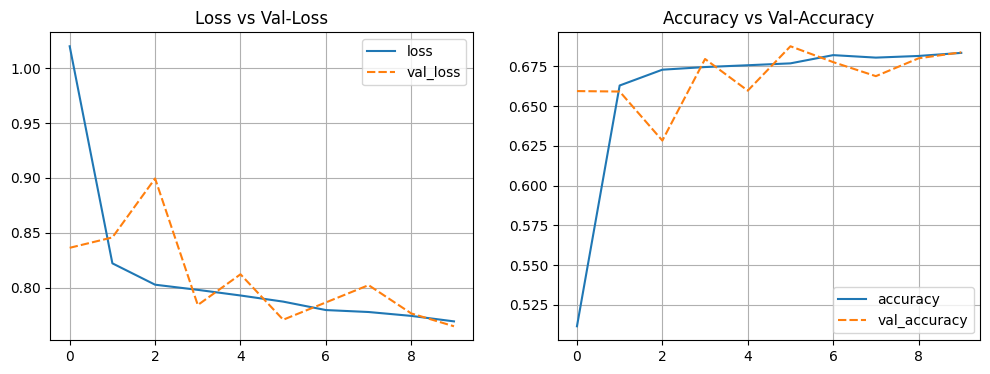

In [42]:
# model evaluation
model_imp_hist_df = pd.DataFrame(model_imp_hist.history)

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_imp_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_imp_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.show()

Dari hasil training improvement model, terlihat bahwa nilai loss berkurang seiring banyaknya epoch yang dilakukan, begitu pula dengan nilai akurasinya yang semakin naik seiring banyaknya epoch yang dilakukan. Hasil dari training improvement model ini termasuk good fit dan memiliki akurasi yang lebih tinggi dari base model, sehingga dapat dikatakan bahwa model improvement berhasil.

In [43]:
# model evaluation (test-set)
y_pred_mod_imp = model_imp.predict(X_ts)
y_pred_imp_class = np.argmax(y_pred_mod_imp, axis=1)
y_pred_imp_class

f1_model_imp = f1_score(y_ts, y_pred_imp_class, average='weighted')

print('F1 Score - Test Set   : ', round(f1_model_base,2), '\n')
print('Classification Report : \n', classification_report(y_ts, y_pred_imp_class), '\n')

372/372 [==============================] - 51s 137ms/step
F1 Score - Test Set   :  0.3 

Classification Report : 
               precision    recall  f1-score   support

           0       0.78      0.78      0.78      5546
           1       0.00      0.00      0.00      1915
           2       0.60      0.86      0.71      4418

    accuracy                           0.68     11879
   macro avg       0.46      0.55      0.50     11879
weighted avg       0.59      0.68      0.63     11879
 



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# G. Model Saving

In [44]:
# Freeze model
# model_base.trainable = False
model_imp.trainable = False

print(model_imp.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 692)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 692, 128)          2758784   
                                                                 
 bidirectional (Bidirection  (None, 692, 40)           5960      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 692, 40)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 20)                1020      
 onal)                                                           
                                                        

In [46]:
with open('preprocess.pkl', 'wb') as file_1:
  pickle.dump(text_preprocessing, file_1)

# save model RNN
model_imp.save('model_imp_SimpleRNN', save_format='tf')
!zip -r model_imp_SimpleRNN.zip model_imp_SimpleRNN

  adding: model_imp_SimpleRNN/ (stored 0%)
  adding: model_imp_SimpleRNN/keras_metadata.pb (deflated 91%)
  adding: model_imp_SimpleRNN/fingerprint.pb (stored 0%)
  adding: model_imp_SimpleRNN/assets/ (stored 0%)
  adding: model_imp_SimpleRNN/saved_model.pb (deflated 86%)
  adding: model_imp_SimpleRNN/variables/ (stored 0%)
  adding: model_imp_SimpleRNN/variables/variables.index (deflated 65%)
  adding: model_imp_SimpleRNN/variables/variables.data-00000-of-00001 (deflated 9%)


# H. Conclusions

1. Pada visualisasi EDA menggunakan wordcloud, review Promoter dan Passive sebelum dan setelah preprocessing memiliki persamaan dalam kata-kata yang sering muncul, yaitu Good, Great, Flight, Comfortable, Offer, dll. Untuk review Detractor sebelum dan setelah preprocessing memiliki kata-kata yang sering muncul adalah Delay, Flight, Hour, Cancel, dll.

2. Dari tahap preprocessing, mengalami kendala yaitu stemmer memotong sebuah kata yang harusnya tidak terpotong (sebagai contoh kata Customer menjadi Custom karena memiliki akhiran -er).

3. Dari hasil model evaluasi, didapatkan bahwa improvement model memiliki tingkat akurasi yang jauh lebih besar daripada base model. Terlihat pada improvement model bahwa nilai loss berkurang seiring banyaknya epoch yang dilakukan, begitu pula dengan nilai akurasinya yang semakin naik seiring banyaknya epoch yang dilakukan. Hasil dari training improvement model ini termasuk good fit dan memiliki akurasi yang lebih tinggi dari base model, sehingga dapat dikatakan bahwa model improvement berhasil dengan menggunakan metode bidirectional dan menambahkan layer dropout dan batchnormalization untuk meningkatkan performa training model.

4. Model ini sangat bisa diimprove lebih baik dengan cara melakukan preprocessing yang sesuai dan mencoba menambahkan hyperparameter lain seperti penambahan hidden layer/neuron, dropout layer, dan juga batchnormalization layer.